In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications

In [3]:
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [4]:
# parameters for data
height = 299
width = 299
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 32

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

# CIFAR-100 dataset
- In order to download `cifar-100` datasets from `keras.datasets`, one should make `Internet` setting  be **on**.
- `cifar-100` contains 50,000 training data and 10,000 testing data each of which is 32 x 32 x 3 images with 1 class out of 100 classes.<br/>
- I could find the label names from [this sites](https://github.com/keras-team/keras/issues/2653)

In [5]:
(X, y), (X_test, y_test) = keras.datasets.cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of X_test : ", X_test.shape)

fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
                    'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
                    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
                    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
                    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
                    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
                    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
                    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

169009152/169001437 [==============================] - 2s 0us/step
The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)


- Plotting some sampled images from randomly chosen 5 classes

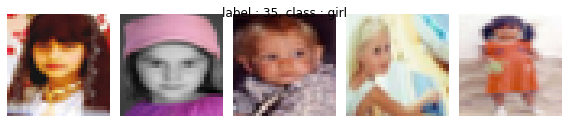

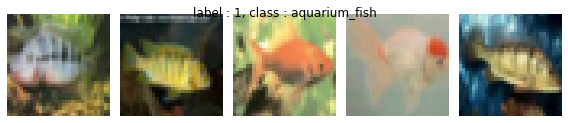

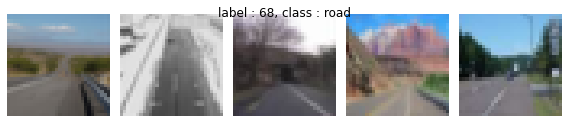

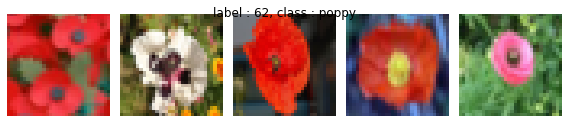

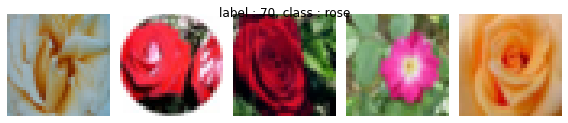

In [6]:
class_plotted = np.random.choice(range(n_classes), 5, replace = False)
for i in range(len(class_plotted)):
    image_samples = X[y.reshape(-1) == class_plotted[i]][:5]
    fig, ax = plt.subplots(nrows = 1, ncols = 5,figsize = (8,8))
    fig.suptitle("label : %d, class : %s" % (class_plotted[i], fine_label_list[class_plotted[i]]), y = .6)
    for j in range(5):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off')  
    fig.tight_layout()
plt.show()

# Data preparation (Chuẩn bị dữ liệu)
- I decided to make the testing data be unknown so I splited the training data into a training data and a validation data.
- Because the number of images for each class in the training data is quite small (500), I used `StratifiedShuffleSplit` method to keep the number of images for each class.

In [7]:
# Spliting the training data into a training data and a validation data.
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

del X, y

The number of training data :  40000
The number of validation data :  10000


- The paper `EfficientNet` says balancing model's depth, model's width and resolution of input images is important for model scaling.
- So original images should be resized to the specified size, which is (224, 224) in the case of `EfficientNetB0`. 
    - When I used the original size (32,32,3), the model's performance was less than 40% (accuracy).
- The bicubic method is a good choice interpolation when upscaling images and it can be implemented by `cv2.INTER_CUBIC`.
- To do this, I used a custom `DataGenerator` that contains the part of resizing a image.

In [8]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

In [10]:
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

In [11]:
print(type(train_generator))

<class '__main__.DataGenerator'>


# Using a pretrained EfficientNetB0

One can easily use EfficientNet models pretrained on `ImageNet` for transfer learnings (or fine tunings) just like other pretrained models.<br/>
The manual to use EfficientNet is well documented at [this site](https://github.com/qubvel/efficientnet).<br/>
To do this I refered to [this site](https://www.dlology.com/blog/transfer-learning-with-efficientnet/).

In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 4.7MB/s 


In [12]:
X_train.shape

(40000, 32, 32, 3)

In [13]:
# Model 1
resnet_model = applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

model_1 = Sequential([
        # UpSampling2D(),
        # UpSampling2D(),
        # UpSampling2D(),
        resnet_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(n_classes, activation='softmax')                   
])

model_1.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 55,177,028
Trainable params: 55,115,460
N

In [ ]:
# Model 2
import efficientnet.keras as efn 
from tensorflow.keras.applications import EfficientNetB0

efnb0 = EfficientNetB0(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)

model_2 = Sequential([
        # UpSampling2D(),
        # UpSampling2D(),
        # UpSampling2D(),
        efnb0,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(n_classes, activation='softmax')                   
])

model_2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 10, 10, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d_22  (None, 1280)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_1849 (Ba (None, 512)               2048      
_________________________________________________________________
dense_43 (Dense)             (None, 100)               51300     
Total params: 4,758,791
Trainable params: 4,715,744
Non-trainable params: 43,047
______________________________________

One can train only fully connected layers by adding the following code
~~~python
efnb0.trainable = False
~~~

## Model 1

In [14]:
# Model 1
model_1_name = 'CW1_model_1.h5'
filepath_1 = os.path.join('/content/drive/MyDrive/CW1/Save_model', model_1_name)

In [15]:
sgd = SGD(learning_rate = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

In [16]:
checkpoint_1 = ModelCheckpoint(filepath=filepath_1,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
callbacks_1 = [es, rlrop, checkpoint_1]

In [17]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

In [ ]:
hist_1 = model_1.fit(train_generator, validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = callbacks_1)


Epoch 1/25
1250/1250 [==============================] - 1563s 1s/step - loss: 2.1415 - acc: 0.4701 - val_loss: 0.9012 - val_acc: 0.7458

Epoch 00001: val_acc improved from -inf to 0.74579, saving model to /content/drive/MyDrive/CW1/Save_model/CW1_model_1.h5
Epoch 2/25
1250/1250 [==============================] - 1516s 1s/step - loss: 1.1186 - acc: 0.6870 - val_loss: 0.6763 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.74579 to 0.79998, saving model to /content/drive/MyDrive/CW1/Save_model/CW1_model_1.h5
Epoch 3/25
1250/1250 [==============================] - 1512s 1s/step - loss: 0.8787 - acc: 0.7474 - val_loss: 0.6586 - val_acc: 0.8089

Epoch 00003: val_acc improved from 0.79998 to 0.80889, saving model to /content/drive/MyDrive/CW1/Save_model/CW1_model_1.h5
Epoch 4/25
1250/1250 [==============================] - 1507s 1s/step - loss: 0.7340 - acc: 0.7875 - val_loss: 0.7640 - val_acc: 0.8035

Epoch 00004: val_acc did not improve from 0.80889
Epoch 5/25
1250/1250 [===========

In [ ]:
model = load_model('/content/drive/MyDrive/coursework1/Resnet_cw1_sample.h5')

In [ ]:
hist = model.fit_generator(train_generator, validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = callbacks)

## Model 2

In [ ]:
# Model 2
model_2_name = 'CW1_model_2.h5'
filepath_2 = os.path.join('/content/drive/MyDrive/CW1/Save_model', model_2_name)

In [ ]:
# sgd = SGD(learning_rate = lr, momentum = 0.9, nesterov = True)
es_2 = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop_2 = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

In [ ]:
checkpoint_2 = ModelCheckpoint(filepath=filepath_2,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)
callbacks_2 = [es_2, rlrop_2, checkpoint_2]

In [ ]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=lr), metrics = ['acc'])

In [ ]:
hist_2 = model_2.fit(train_generator, validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = callbacks_2)


Epoch 1/25
1250/1250 [==============================] - 1038s 822ms/step - loss: 2.6384 - acc: 0.3385 - val_loss: 8.3975 - val_acc: 0.0100
Epoch 2/25
  30/1250 [..............................] - ETA: 15:18 - loss: 1.8531 - acc: 0.4823

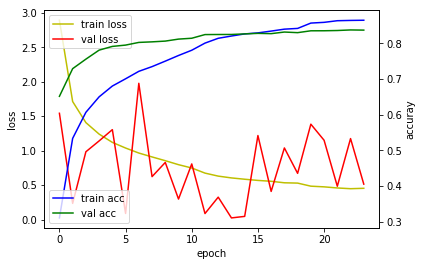

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Inference
- For your quick experiment, I have uploaded the best weight for the model.
- To load the fine-tuned weight, follow a few steps
    - click `Add Data`
    - click `Kernel output files`
    - find this kernel
    - click `Add`

In [1]:
# model.load_weights("../input/%s/best_weight.h5" % (os.listdir('../input')[0]))
print("The Accuracy on the validation data : {:.2f}%".format(100 * model_1.evaluate_generator(valid_generator, verbose = 1)[-1]))

NameError: ignored

- Before inference, make sure to set `shuffle=False` in test generator. 
    - If not, predictions cannot be compared  with true labels because test generator predicts output in the shuffled order.

In [ ]:
# Make sure to set shuffle be False.
test_generator = DataGenerator(X_test, mode = 'predict', augment = False, shuffle = False)
y_pred = model.predict_generator(test_generator,verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

print("The accuracy on the testing data : {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))

1250/1250 [==============================] - 38s 30ms/step
The accuracy on the testing data : 82.22%
